# Econ 212: Problem Set 3

In [1]:
from fredapi import Fred
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import numpy.linalg as la
import pandas as pd

In [2]:
fred = Fred(api_key = 'f6fa4f544be19c2ea791e9a3240470bf')

## Problem 1: Seignorage and inflation

## Problem 2: SVAR impulse response to monetary shocks

### Part A

In [3]:
real_GDP = fred.get_series('GDPC1', observation_start = '1959-01-01', observation_end = '2007-10-01')
price_deflator = fred.get_series('GDPDEF', observation_start = '1959-01-01', observation_end = '2007-10-01')
fed_funds_rate = fred.get_series('FEDFUNDS', observation_start = '1959-01-01', observation_end = '2007-12-01')

In [4]:
growth_rate = [400 * np.log(real_GDP[t] / real_GDP[t-1]) for t in range(1,len(real_GDP))]
inflation_rate = [400 * np.log(price_deflator[t] / price_deflator[t-1]) for t in range(1,len(price_deflator))]
fed_funds_rate = np.mean(np.reshape(fed_funds_rate, (3, len(fed_funds_rate) // 3), order = 'F'), axis = 0)[1:]

### Part B

### i

In [5]:
# Contemporaneous values
Xt = np.array([growth_rate, inflation_rate, fed_funds_rate])

Xt_df = pd.DataFrame(Xt.T, columns = ['growth_rate', 'inflation_rate', 'fed_funds_rate'])

# Create lags 1 - 4
lagged_Xt = pd.concat((Xt_df.shift(1), Xt_df.shift(2), Xt_df.shift(3), Xt_df.shift(4)), axis = 1)

# Rename columns
for i in range(4):
    lagged_Xt.columns.values[0 + 3 * i] = f'growth_rate{i}'
    lagged_Xt.columns.values[1 + 3 * i] = f'inflation_rate{i}'
    lagged_Xt.columns.values[2 + 3 * i] = f'fed_funds_rate{i}'

# Drop the first four rows
lagged_Xt = lagged_Xt.iloc[4:]

In [6]:
# Run regression on lagged values
B_gamma_inv = np.linalg.inv(lagged_Xt.T @ lagged_Xt) @ lagged_Xt.T @ Xt_df[4:]
B_gamma_inv = np.matrix(B_gamma_inv)

# Get coefficients for each lag
B_gamma_inv_1 = B_gamma_inv[0:3, :]
B_gamma_inv_2 = B_gamma_inv[3:6, :]
B_gamma_inv_3 = B_gamma_inv[6:9, :]
B_gamma_inv_4 = B_gamma_inv[9:12, :]

# Calculate residuals
residuals = np.matrix(Xt_df[4:]) - lagged_Xt @ B_gamma_inv

# Get L
L = np.linalg.cholesky(np.cov(residuals.T))

In [7]:
# Shock is 100 bps, or 1 percentage point. Normalize to 1 SD
shock = [0, 0, 1 / np.std(fed_funds_rate)]

# Seed the IRF with initial periods
irf = np.zeros((15, 3))
irf[0] = np.dot(L, shock)
irf[1] = B_gamma_inv_1.T @ irf[0]
irf[2] = B_gamma_inv_1.T @ irf[1] + B_gamma_inv_2.T @ irf[0]
irf[3] = B_gamma_inv_1.T @ irf[2] + B_gamma_inv_2.T @ irf[1] + B_gamma_inv_3.T @ irf[0]

# Iterate forward through time
for t in range(4, 15):
    irf[t] = B_gamma_inv_1.T @ irf[t-1] + B_gamma_inv_2.T @ irf[t-2] + B_gamma_inv_3.T @ irf[t-3] + B_gamma_inv_4.T @ irf[t-4]

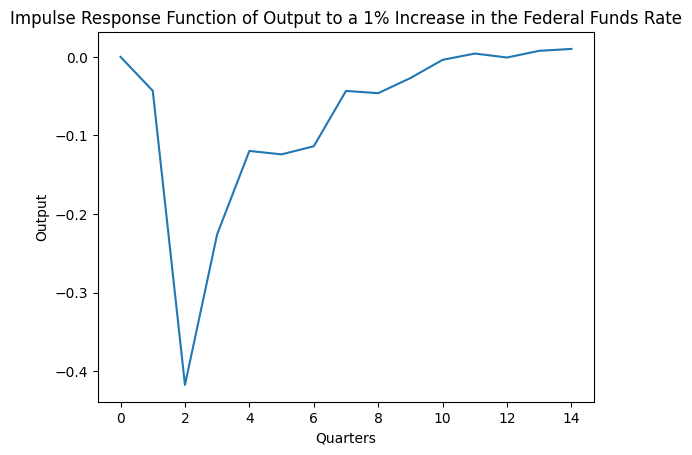

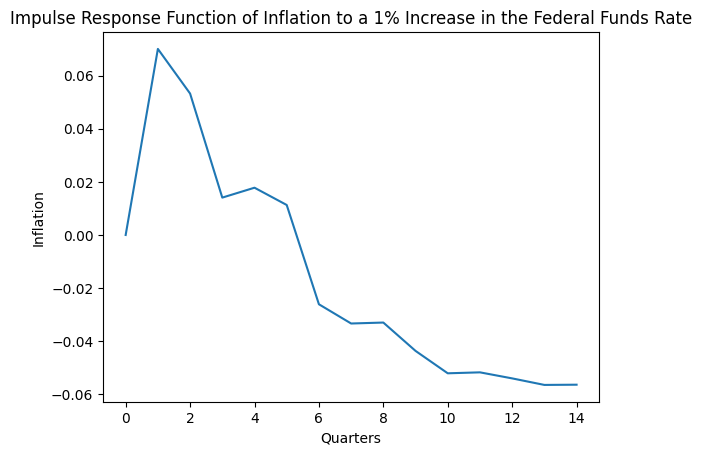

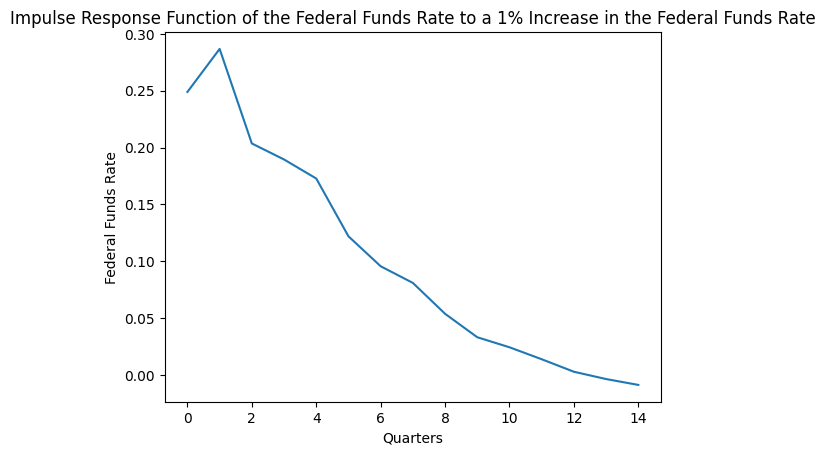

In [8]:
# Plot first column of irf representing output
plt.plot(irf[:, 0])
plt.title('Impulse Response Function of Output to a 1% Increase in the Federal Funds Rate')
plt.xlabel('Quarters')
plt.ylabel('Output')
plt.show()

# Plot second column of irf representing inflation
plt.plot(irf[:, 1])
plt.title('Impulse Response Function of Inflation to a 1% Increase in the Federal Funds Rate')
plt.xlabel('Quarters')
plt.ylabel('Inflation')
plt.show()

# Plot third column of irf representing the federal funds rate
plt.plot(irf[:, 2])
plt.title('Impulse Response Function of the Federal Funds Rate to a 1% Increase in the Federal Funds Rate')
plt.xlabel('Quarters')
plt.ylabel('Federal Funds Rate')
plt.show()


In [9]:
def plot_var_irf(X, periods, shock, var_list):
    # fit model
    model = VAR(X).fit(1, trend = 'n')
    
    # get L matrix
    b_gamma_inv = model.coefs
    sigma = np.cov(np.matrix(model.resid).T)
    L = la.cholesky(sigma).T

    # compute IRF and scaled response function
    irf = [(b_gamma_inv ** t) @ L for t in  range(periods)]
    response = [irf[t] @ shock for t in range(periods)]
    
    # plot
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)

    for i in range(np.shape(X)[1]):
        irf_series = [response[t][0][i] for t in range(periods)]
        var = var_list[i]

        ax = plt.subplot(np.shape(X)[1], 1, i + 1)

        ax.plot(irf_series, linewidth=2.5)
        ax.set_title(f'{var} response to 100 bp monetary innovation')
        ax.set_ylabel('deviation from steady state')
        ax.set_xlabel('quarters')
        ax.axhline(0, color = "r", linestyle = "--")
    plt.show()

In [10]:
plot_var_irf(X, 12, shock, var_list)

NameError: name 'X' is not defined

### ii

In [ ]:
X_permuted = [(inflation_rate[t], growth_rate[t], fed_funds_rate[t]) for t in range(len(inflation_rate))]
var_list_permuted = ['Inflation Rate','Growth Rate', 'Nominal Interest Rate']

plot_var_irf(X_permuted, 12, shock, var_list_permuted)

### iii

In [ ]:
total_reserves = np.log(fred.get_series('TOTRESNS', observation_start = '1959-01-01', 
                                        observation_end = '2007-10-01')[::3])
m2 = np.log(fred.get_series('M2SL', observation_start = '1959-01-01', 
                                        observation_end = '2007-10-01')[::3])

In [ ]:
X_additional = [(growth_rate[t], inflation_rate[t], total_reserves[t], m2[t] ,fed_funds_rate[t]) 
                for t in range(len(fed_funds_rate))]

shock = [0,0,0,0,1/sd_ff]
var_list = ['Growth Rate','Inflation Rate','Log total reserves', 'Log M2', 'Nominal Interest Rate']

In [ ]:
plot_var_irf(X_additional, 12, shock, var_list)

In [ ]:
def compute_irf(X, periods, shock):
    model_boot = VAR(X).fit(1, trend = 'n')
            
    # get L matrix
    b_gamma_inv_boot = model_boot.coefs
    sigma_boot = np.cov(np.matrix(model_boot.resid).T)
    L_boot = la.cholesky(sigma_boot).T

    # compute IRF and scaled response function
    irf_boot = [(b_gamma_inv_boot ** t) @ L_boot for t in  range(periods)]
    response_boot = [irf_boot[t] @ shock for t in range(periods)]
    
    return(response_boot)

In [ ]:
def bootstrap_irf(X, K, periods, shock, var_list):
    # fit model
    model = VAR(X).fit(1, trend = 'n')
    
    # get L matrix
    b_gamma_inv = model.coefs
    sigma = np.cov(np.matrix(model.resid).T)
    L = la.cholesky(sigma).T

    # compute IRF and scaled response function
    irf = [(b_gamma_inv ** t) @ L for t in  range(periods)]
    response = [irf[t] @ shock for t in range(periods)]
    
    # residuals
    epsilons = model.resid
    
    # make some useful constants
    covs = np.shape(X)[1]
    n = np.shape(X)[0]
    
    # make 3 dimensional matrix to store irfs
    response_array = np.zeros((n, covs, K))
    
    for k in range(K):
        eps_boot = np.zeros((n, covs))

        for i in range(covs):
            eps_boot[:, i] = np.random.choice(epsilons[i, :], size = n, replace = True)

        X_boot = X @ b_gamma_inv + eps_boot
        response_array[:,:, k] = compute_irf(X_boot[0], periods, shock)[0]
        
    # plot
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)

    for i in range(np.shape(X)[1]):
        irf_series = [response[t][0][i] for t in range(periods)]
        
        # get the 5th and 95th percentile outcomes        
        irf_upper_ci = [np.percentile(response_array[t][i], 97.5) for t in range(periods)]
        irf_lower_ci = [np.percentile(response_array[t][i], 2.5) for t in range(periods)]
    
        var = var_list[i]

        ax = plt.subplot(np.shape(X)[1], 1, i + 1)

        ax.plot(irf_series, linewidth=2.5)
        ax.plot(irf_upper_ci, linewidth = 2.5, color = "b")
        ax.plot(irf_lower_ci, linewidth = 2.5, color = "b")
        ax.set_title(f'{var} response to 100 bp monetary innovation')
        ax.set_ylabel('deviation from steady state')
        ax.set_xlabel('quarters')
        ax.axhline(0, color = "r", linestyle = "--")
    plt.show()

In [ ]:
bootstrap_irf(X, 10, 10, shock, var_list)